This jupyter notebook numerically computes the approximation of the analytical solution for the steady state temperature field established from a heated wall in an established laminar flow. The solution relies on a splitting between asymptotic solution for $x \to \infty$ and the homogeneous term, computed through separation of space variables $x$ and $y$. 

Details for the mathematical derivation are given in the associated document.

Below, this first cell defines the functions that are used to find the eigenvalues and eigenvectors in the development of the homogeneous solution in a truncated trigonometric series, for odd (sine) and even (cosine) modes.

It also defines the function to compute the coefficients in the series expansion of the homogeneneous solution, that are related to the inlet condition of the problem.

In [2]:
import scipy as scp
from scipy.linalg import eigh
import numpy as np

def even_modes(N):
    # Cosine series
    D = np.zeros((N,N))
    for i in range(N):
        if i==0:
            D[i,i] = 0
        else:
            D[i,i] = -(i*np.pi)**2
    
    M = np.zeros((N,N))
    
    for i in range(N):
        for j in range(N):
            if i==0 and j==0:
                M[i,j]=2
            elif i>0 and i==j:
                M[i,j] = 1 - 3/(4*(i*np.pi)**2)
            else:
                M[i,j] = -(3/(np.pi**2)) * ( ((-1)**(i-j))/((i-j)**2) + ((-1)**(i+j))/((i+j)**2) )
    
    Kc, Ac = eigh(-D, M)

    return (Kc, Ac, M)


def odd_modes(N):
    # Sine series
    
    D = np.zeros((N,N))
    for i in range(N):
        D[i,i] = -((i+1/2)*np.pi)**2
    
    M = np.zeros((N,N))
    
    for i in range(N):
        for j in range(N):
            if i==j:
                M[i,j] = 1 - 3/(((2*i+1)*np.pi)**2)
            else:
                M[i,j] = -(3/(np.pi**2)) * ( ((-1)**(i-j))/((i-j)**2) + ((-1)**(i+j))/((i+j+1)**2) )
    
    Ks, As = eigh(-D, M)

    return (Ks, As, M)


def compute_coefficients(theta_0, u_tilde, vectors_a, matrix_M, mode='even'):
    """
    Computation of c_n coefficients for cosine series (even modes) or sine series (odd modes)
    
    Parameters:
    - theta_0:   Boundary condition for X=0 for theta tilde
    - N:         Truncature for the series expansion
    - vectors_a: The Matrix of eigenvectors (columns are a_c,n).
    - matrix_M:  The Mass Matrix M (computed previously).
    
    Returns:
    - C: Array of coefficients c_n for n = 0 to N-1
    """

    N = len(vectors_a[0])

    # Discretization of [-1,1] space for numerical integration
    Y_fine = np.linspace(-1, 1, 2000)
    dy = Y_fine[1] - Y_fine[0]
    
    # Precomputing of the weight function times the inlet condition
    # for theta tilde
    u_vals = u_tilde(Y_fine)
    theta_0_vals = theta_0(Y_fine)
    
    # Calculation of theta_0 x u_tilde on all points
    weighted_theta_0 = theta_0_vals * u_vals
    
    # Compute total projection vector h for each cos(k*pi*Y)
    # Vector h is of size N. Element k is the intergral over [-1,1] of u_tilde x theta_0 x cos(k*pi*Y)
    h = np.zeros(N)
    
    for k in range(N):
        if mode == 'even':
            # Generate base function of even modes cos(k*pi*Y) on the Y discretization
            basis = np.cos(k * np.pi * Y_fine)
        else :
            # Generate base function of odd modes sin((k+1/2)*pi*Y) on the Y discretization
            basis = np.sin((k + 1/2) * np.pi * Y_fine)
            
        # Compute the integral using trapezoidal rule
        integrand = weighted_theta_0 * basis
        h[k] = np.trapezoid(integrand, dx=dy)
        
    # Calculation of the c_n coefficients using the vectorized formula:
    # c_n = (a_n . h) / (a_n^T . M . a_n)
    
    C = np.zeros(N)
    
    for n in range(N):
        # Extract the n-th eigenvector (column n)
        a_n = vectors_a[:, n]

        # @ operator = matrix product (equivalent to np.dot)
        C[n] = np.dot(a_n, h) / (a_n.T @ matrix_M @ a_n)
        
    return C

The cell below defines the main physical and dimensionless variables of the problem.
- $h$ the half-height of the channel
- $\mathrm{Re}$ the Reynolds number of the considered flow
- $D_h$ the hydraulic diameter of the channel
- $q_w$ the wall heat flux
- $T_{in}$ the inlet liquid temperature

The problem solved is the steady-state temperature field in the channel (coordinates $x\in [0, x_{max}]$, $y \in [-1,1]$) heated at a constant heat flux $q_w$ at the boundary $y=-h$ and a zero heat-flux condition at $y=h$. 
The liquid flow is established and follows the laminar plate profile $u(y) = U_{max}\left(1-y^2/h^2\right)$, entering in $x=0$ at $T_{in}$.

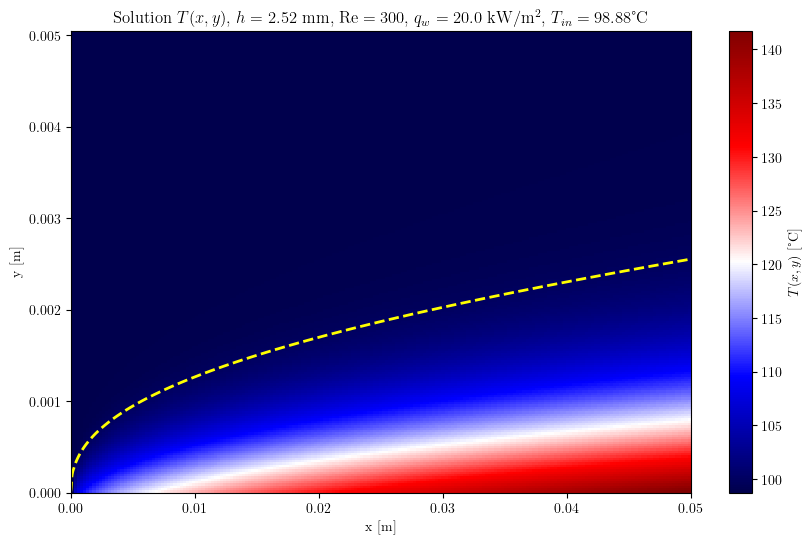

In [4]:
import sys
sys.path.append('..')
from fluid_ppt import *

# ==========================================
# 1. Physical properties of the problem
# ==========================================

# Fluid properties
ppt = fluid_ppt_sat('water', 1.01e5) # Fluid properties at saturation, indicating fluid name and operating pressure 
alpha = ppt['alpha_l'] # Liquid thermal diffusivity [m2/s]
lam_l = ppt['lam_l'] # Liquid heat conductivity [W/m/K]

# Channel geometry
h = 5.05e-3/2 # Channel half height [m]
Dh = 8.97e-3 # Channel hydraulic diameter [m]

x_max = 5e-2 # Maximum axial distance over which the problem is solved [m]

# Laminar flow
Re = 300 # Flow reynolds number [-]
u_moy = Re * ppt['nu_l'] / Dh # Flow average velocity [m/s]

# Thermal parameters
qw =20e3 # Wall heat flux at y=-h [W/m2]
Tin = ppt['Tsat']-1 # Inlet temperature [°C]


# ==========================================
# 2. Dimensionless functions
# ==========================================

# Non-dimensional velocity profile u tilde
def ut(y):
    return 3/2*(1-y**2)

# Asymptotic solution to the dimensionless temperature problem
def Theta_inf(x,y):
    return 0.5*x - (1/16)*(y**4) + (3/8)*(y**2) - 0.5*y

# Inlet boundary condition for the homogeneous solution theta tilde
def thet0(y):
    return - Theta_inf(0,y)


# ==========================================
# 3. Numerical approximation of the analytical solution
# ==========================================

N = 20 # Maximum order in the infinite expansion series for the non-dimensional homogeneous temperature solution theta_tilde

# Even modes (cosines)
(Kc, Ac, Mc) = even_modes(N) # Kc = eigenvalues, Ac = eigenvectors, Mc = Mass matrix for eigenvalue problem
Cc = compute_coefficients(thet0, ut, Ac, Mc, mode='even') # Coefficients in theta_tilde development for even modes

# Odd modes (sines)
(Ks, As, Ms) = odd_modes(N) # Ks = eigenvalues, As = eigenvectors, Ms = Mass matrix for eigenvalue problem
Cs = compute_coefficients(thet0, ut, As, Ms, mode='odd') # Coefficients in theta_tilde development for odd modes

# Homogeneous solution theta_tilde approximated with N terms for odd and even modes
def theta_tilde(x,y): 
    res = 0
    for n in range(N):
        g_even = 0 # n-th even mode value
        ac_n = Ac[:,n] # n-th even mode eigenvector
        
        g_odd = 0 # n-th odd mode value
        as_n = As[:,n] # n-th odd mode eigenvector
        for k in range(N):
            # Summing over cos and sin basis for calculation of even and odd n-th mode value
            g_even += ac_n[k] * np.cos(k * np.pi * y)
            g_odd += as_n[k] * np.sin((k+1/2) * np.pi * y)

        res += Cc[n]*np.exp(-Kc[n]*x)*g_even + Cs[n]*np.exp(-Ks[n]*x)*g_odd

    return res

# Final total dimensionless temperature field
def theta(x,y):
    res = Theta_inf(x,y) + theta_tilde(x,y)
    return res


# ==========================================
# 4. Plotting the results over the chosen range
# ==========================================

import matplotlib.pyplot as plt
from matplotlib import rc
# Font selection --> LaTeX style
rc('font',**{'family':'serif','serif':['Computer Modern'], 'size' : 10})
rc('text', usetex=True)


# Bounds of the dimensionless doomain
X_max_real = x_max # Maximum real x in m defined above
X_min, X_max = 0, alpha*X_max_real/(u_moy*(h**2))   # Axial direction
Y_min, Y_max = -1, 1    # Radial direction

Ny = 200 # Number of points in the Y-direction
Nx = 200 # Number of points in the X-direction


# Lists of values evenly spaced for X and Y
x = np.linspace(X_min, X_max, Nx)
y = np.linspace(Y_min, Y_max, Ny)

# Create the associated 2D mesh array
X_grid, Y_grid = np.meshgrid(x, y)

# Evaluating Theta on the the (X,Y) values
Theta_values = theta(X_grid[:-1, :-1], Y_grid[:-1, :-1])

# Retrieving the real physical coordinates
Y_real = h * Y_grid + h
X_real = (u_moy * (h**2) / alpha) * X_grid

# Retrieving the real temperature values
T_real = qw * (h/ppt['lam_l']) * Theta_values + Tin

# Plotting the results
plt.figure(figsize=(10, 6))

# 2D heatmap function plotting
plot = plt.pcolormesh(
    X_real, Y_real, T_real, 
    cmap='seismic',   # Colormap
    shading='flat',   # Does not interpolate and keeps the discretized values
)

# Add the colorbar
cbar = plt.colorbar(plot)
cbar.set_label(r'$T(x, y)$ [°C]')

# Title and axes labels
plt.title(rf'Solution $T(x,y)$, $h={round(h*1000,2)}$\ mm, $\mathrm{{{{Re}}}}={Re}$, $q_w={round(qw/1000,1)}$\ kW/m$^2$, $T_{{in}}={round(Tin,2)}$°C')
plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.axis('tight') # Fitting axes to the data range

# Computing the isoline at T = 1.01 x T_in to identify the thermal boundary layer thickness
isoline_plot = plt.contour(
    X_real[:-1, :-1], Y_real[:-1, :-1], T_real,
    levels=[1.01 * Tin],         # Draw the isoline at T = 1.01 x T_in
    colors='yellow',
    linestyles='--',
    linewidths=2              
)

# Saving figure
plt.savefig('TBL.pdf', format='pdf')

# Saving the isoline coordinates -> retrieving TBL thickness
# Initialize a list to store all (x, y) coordinates for the isoline
isoline_coords = []

# Iterate through the isoline  at the given temperature value
segments = isoline_plot.allsegs
segment = np.array(segments[0][0])

# Final results : x_coords and y_coords contain the coordinates x and y of the points corresponding to the isoline T = 1.01 x T_in
x_coords = segment[:, 0]
y_coords = segment[:, 1]